In [242]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

2.3.0
0.6.0
4.3.2


### 1) 데이터 준비와 확인

In [85]:
import pandas as pd
import os

# 데이터를 읽어봅시다.
train_data = pd.read_table(os.getenv("HOME") + '/work/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table(os.getenv("HOME") + '/work/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) Dataloader 구성

In [95]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [96]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [100]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공

In [104]:
total_data_text = list(X_train)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.983144299571766
문장길이 최대 :  116
문장길이 표준편차 :  12.824863915293127
pad_sequences maxlen :  41
전체 문장의 0.9341300570521679%가 maxlen 설정값 이내에 포함됩니다. 


In [105]:
import torch 
import torch.nn.functional as F

def maxcut_sequences(data, maxlen):
    cutted_data = []
    for sentence in data:
        if len(sentence) > maxlen:
            sentence = sentence[:maxlen]
        cutted_data.append(torch.tensor(sentence, dtype=torch.long))
    return cutted_data

x_train_cutted = maxcut_sequences(X_train, maxlen)
x_test_cutted = maxcut_sequences(X_test, maxlen)

x_train_padded = torch.nn.utils.rnn.pad_sequence(x_train_cutted, batch_first=True, padding_value=word_to_index['<PAD>'])
x_test_padded = torch.nn.utils.rnn.pad_sequence(x_test_cutted, batch_first=True, padding_value=word_to_index['<PAD>'])


print(x_train_padded.shape)

torch.Size([146182, 41])


### 4) 모델 구성 및 validation set 구성

In [106]:
# validation set 40000건 분리
x_val = x_train_padded[:40000]
y_val = y_train[:40000]

# validation set을 제외한 나머지 106182건
partial_x_train = x_train_padded[40000:]
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

torch.Size([106182, 41])
(106182,)


In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F

vocab_size = 10000    # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
class SentimentModel_1(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(SentimentModel_1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.lstm = nn.LSTM(word_vector_dim, word_vector_dim, num_layers=3, batch_first=True)
        self.fc1 = nn.Linear(word_vector_dim, word_vector_dim)
        self.fc2 = nn.Linear(word_vector_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = SentimentModel_1(vocab_size, word_vector_dim)
print(model)

SentimentModel_1(
  (embedding): Embedding(10000, 300)
  (lstm): LSTM(300, 300, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=1, bias=True)
)


In [109]:
from torchinfo import summary

summary(model, input_size=(16,41), dtypes=[torch.long]) # 5,257,801

Layer (type:depth-idx)                   Output Shape              Param #
SentimentModel_1                         [16, 1]                   --
├─Embedding: 1-1                         [16, 41, 300]             3,000,000
├─LSTM: 1-2                              [16, 41, 300]             2,167,200
├─Linear: 1-3                            [16, 300]                 90,300
├─Linear: 1-4                            [16, 1]                   301
Total params: 5,257,801
Trainable params: 5,257,801
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.47
Input size (MB): 0.01
Forward/backward pass size (MB): 3.19
Params size (MB): 21.03
Estimated Total Size (MB): 24.22

In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F

vocab_size = 10000    # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
class SentimentModel_2(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(SentimentModel_2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.conv1 = nn.Conv1d(word_vector_dim, word_vector_dim, kernel_size=7)
        self.conv2 = nn.Conv1d(word_vector_dim, word_vector_dim, kernel_size=7)
        self.conv3 = nn.Conv1d(word_vector_dim, word_vector_dim, kernel_size=7)
        self.pool1 = nn.MaxPool1d(2)
        self.global_maxpool = nn.AdaptiveMaxPool1d(1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(word_vector_dim, word_vector_dim)
        self.fc2 = nn.Linear(word_vector_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.global_maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = SentimentModel_2(vocab_size, word_vector_dim)
print(model)

SentimentModel_2(
  (embedding): Embedding(10000, 300)
  (conv1): Conv1d(300, 300, kernel_size=(7,), stride=(1,))
  (conv2): Conv1d(300, 300, kernel_size=(7,), stride=(1,))
  (conv3): Conv1d(300, 300, kernel_size=(7,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_maxpool): AdaptiveMaxPool1d(output_size=1)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=1, bias=True)
)


In [132]:
summary(model, input_size=(16,41), dtypes=[torch.long]) # 4,981,501

Layer (type:depth-idx)                   Output Shape              Param #
SentimentModel_2                         [16, 1]                   --
├─Embedding: 1-1                         [16, 41, 300]             3,000,000
├─Conv1d: 1-2                            [16, 300, 35]             630,300
├─ReLU: 1-3                              [16, 300, 35]             --
├─MaxPool1d: 1-4                         [16, 300, 17]             --
├─Conv1d: 1-5                            [16, 300, 11]             630,300
├─ReLU: 1-6                              [16, 300, 11]             --
├─Conv1d: 1-7                            [16, 300, 5]              630,300
├─ReLU: 1-8                              [16, 300, 5]              --
├─AdaptiveMaxPool1d: 1-9                 [16, 300, 1]              --
├─Linear: 1-10                           [16, 300]                 90,300
├─ReLU: 1-11                             [16, 300]                 --
├─Linear: 1-12                           [16, 1]           

In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F

vocab_size = 10000    # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
class SentimentModel_3(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, filter_sizes):
        super(SentimentModel_3, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)

        conv = []
        for size in filter_sizes:
            conv.append(
                nn.Sequential(
                    nn.Conv1d(
                        in_channels=word_vector_dim,
                        out_channels=word_vector_dim,
                        kernel_size=size
                    ),
                    nn.ReLU(),

                    nn.Conv1d(
                        in_channels=word_vector_dim,
                        out_channels=1,
                        kernel_size=size
                    ),
                    nn.ReLU(),
                    nn.AdaptiveMaxPool1d(1),
                )
            )
        self.conv_filters = nn.ModuleList(conv)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        output_size = len(filter_sizes)
        self.fc1 = nn.Linear(output_size, output_size)
        self.fc2 = nn.Linear(output_size, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)

        conv_outputs = [conv(x) for conv in self.conv_filters]
        concat_outputs = torch.cat([conv.squeeze(-1) for conv in conv_outputs], dim=1)
        
        x = self.fc1(concat_outputs)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = SentimentModel_3(vocab_size, word_vector_dim, filter_sizes=[3,3,4,4,5,5])
print(model)

SentimentModel_3(
  (embedding): Embedding(10000, 300)
  (conv_filters): ModuleList(
    (0-1): 2 x Sequential(
      (0): Conv1d(300, 300, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(300, 1, kernel_size=(3,), stride=(1,))
      (3): ReLU()
      (4): AdaptiveMaxPool1d(output_size=1)
    )
    (2-3): 2 x Sequential(
      (0): Conv1d(300, 300, kernel_size=(4,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(300, 1, kernel_size=(4,), stride=(1,))
      (3): ReLU()
      (4): AdaptiveMaxPool1d(output_size=1)
    )
    (4-5): 2 x Sequential(
      (0): Conv1d(300, 300, kernel_size=(5,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(300, 1, kernel_size=(5,), stride=(1,))
      (3): ReLU()
      (4): AdaptiveMaxPool1d(output_size=1)
    )
  )
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=6, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=1, bias=True)
)


In [141]:
summary(model, input_size=(16,41), dtypes=[torch.long]) # 5,169,055

Layer (type:depth-idx)                   Output Shape              Param #
SentimentModel_3                         [16, 1]                   --
├─Embedding: 1-1                         [16, 41, 300]             3,000,000
├─ModuleList: 1-2                        --                        --
│    └─Sequential: 2-1                   [16, 1, 1]                --
│    │    └─Conv1d: 3-1                  [16, 300, 39]             270,300
│    │    └─ReLU: 3-2                    [16, 300, 39]             --
│    │    └─Conv1d: 3-3                  [16, 1, 37]               901
│    │    └─ReLU: 3-4                    [16, 1, 37]               --
│    │    └─AdaptiveMaxPool1d: 3-5       [16, 1, 1]                --
│    └─Sequential: 2-2                   [16, 1, 1]                --
│    │    └─Conv1d: 3-6                  [16, 300, 39]             270,300
│    │    └─ReLU: 3-7                    [16, 300, 39]             --
│    │    └─Conv1d: 3-8                  [16, 1, 37]               

### 5) 모델 훈련 개시

In [142]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

x_val_tensor = torch.tensor(x_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

epochs = 30   # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
train_losses = []
val_losses = []
train_accs = []
val_accs = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # cuda 또는 cpu 출력
model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

/tmp/ipykernel_10511/2649448084.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
/tmp/ipykernel_10511/2649448084.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


cuda
Epoch 1/30 - Train Loss: 0.5104, Train Accuracy: 0.7418 - Validation Loss: 0.4176, Validation Accuracy: 0.8029
Epoch 2/30 - Train Loss: 0.3708, Train Accuracy: 0.8332 - Validation Loss: 0.3781, Validation Accuracy: 0.8288
Epoch 3/30 - Train Loss: 0.3100, Train Accuracy: 0.8672 - Validation Loss: 0.3670, Validation Accuracy: 0.8379
Epoch 4/30 - Train Loss: 0.2555, Train Accuracy: 0.8955 - Validation Loss: 0.3870, Validation Accuracy: 0.8336
Epoch 5/30 - Train Loss: 0.2029, Train Accuracy: 0.9216 - Validation Loss: 0.4138, Validation Accuracy: 0.8361
Epoch 6/30 - Train Loss: 0.1526, Train Accuracy: 0.9437 - Validation Loss: 0.4906, Validation Accuracy: 0.8328
Epoch 7/30 - Train Loss: 0.1119, Train Accuracy: 0.9613 - Validation Loss: 0.5441, Validation Accuracy: 0.8349
Epoch 8/30 - Train Loss: 0.0835, Train Accuracy: 0.9725 - Validation Loss: 0.6149, Validation Accuracy: 0.8312
Epoch 9/30 - Train Loss: 0.0696, Train Accuracy: 0.9771 - Validation Loss: 0.6640, Validation Accuracy: 0.8

In [143]:
save_dir = os.path.join(os.getenv('HOME') + '/work/sentiment_classification/')

torch.save(model, save_dir + "multi_cov_model.pth")
torch.save(model.state_dict(), save_dir + "multi_cov_model_weights.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


#### Test set 평가

In [144]:
test_dataset = TensorDataset(x_test_padded, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 1.3071, Test Accuracy: 0.8270


In [145]:
history = {'val_accuracy': val_accs}
history['train_accuracy']= train_accs
history['val_loss']= val_losses
history['train_loss']= train_losses

history['test_loss'] = test_loss / len(test_loader)
history['test_acc'] = test_correct / test_total

In [146]:
import pickle

# save data
with open(save_dir + 'multi_conv_model_history.pickle','wb') as fw:
    pickle.dump(history, fw)


### 6) Loss, Accuracy 그래프 시각화

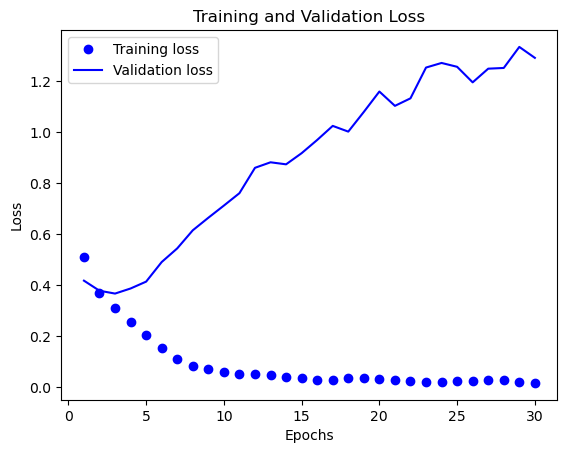

In [147]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

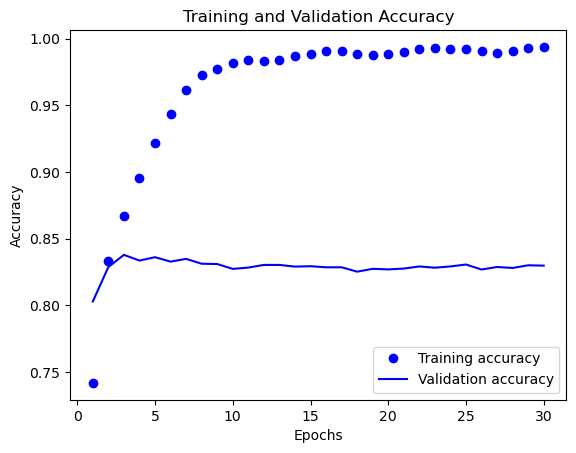

In [148]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 3가지 모델 성능 비교

In [149]:
# load data
with open(save_dir + 'lstm_model_history.pickle', 'rb') as fr:
    history_lstm = pickle.load(fr)

with open(save_dir + 'conv_model_history.pickle', 'rb') as fr:
    history_conv = pickle.load(fr)

with open(save_dir + 'multi_conv_model_history.pickle', 'rb') as fr:
    history_multi_conv = pickle.load(fr)


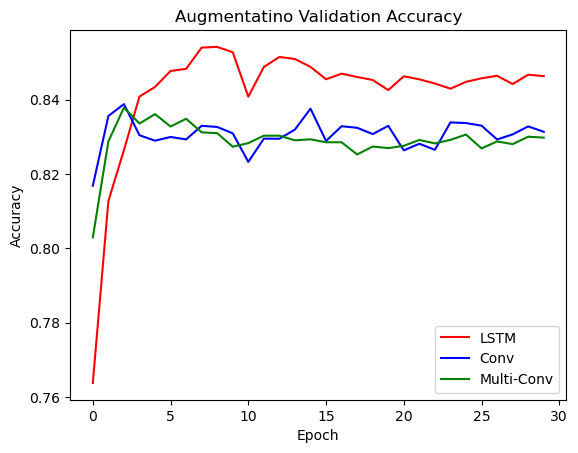

In [150]:
import matplotlib.pyplot as plt

plt.plot(history_lstm['val_accuracy'], 'r', label="LSTM")
plt.plot(history_conv['val_accuracy'], 'b', label="Conv")
plt.plot(history_multi_conv['val_accuracy'], 'g', label="Multi-Conv")


plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

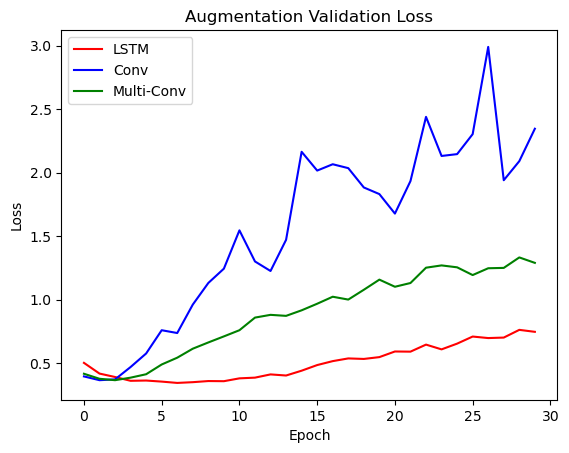

In [151]:
plt.plot(history_lstm['val_loss'], 'r', label="LSTM")
plt.plot(history_conv['val_loss'], 'b', label="Conv")
plt.plot(history_multi_conv['val_loss'], 'g', label="Multi-Conv")

plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [157]:
print('LSTM Val acc: ', max(history_lstm['val_accuracy']))
print('Conv Val acc: ', max(history_conv['val_accuracy']))
print('Multi-Conv Val acc: ', max(history_multi_conv['val_accuracy']))

print('LSTM Test acc: ', history_lstm['test_acc'])
print('Conv Test acc: ', history_conv['test_acc'])
print('Multi-Conv Test acc: ', history_multi_conv['test_acc'])

LSTM Val acc:  0.854225
Conv Val acc:  0.838825
Multi-Conv Val acc:  0.837875
LSTM Test acc:  0.8474479728217751
Conv Test acc:  0.8293427182293468
Multi-Conv Test acc:  0.8269625892548366


|Model|Val-acc|Test-acc|
|------|---|---|
|LSTM|85.42|84.74|
|Conv|83.88|82.93|
|Multi-Conv|83.79|82.70|

- 실험한 모델은 LSTM, Conv, Multi-Conv 모델로, 각 모델의 파라미터 수를 비슷하게 맞춰 보다 정확한 성능 비교를 하고자 했다. 
- 세 가지 모델을 비교했을 때 LSTM 모델이 84.74로 가장 높은 test set 정확도를 달성했다.
- Convolution 연산은 주변 단어들을 함께 살펴보며, 지역적인 맥락 파악에 특화되어 있다. 그에 반해 LSTM은 모든 단어들의 정보를 보존한 채로 학습이 진행되기에 sequence의 전체 맥락을 파악하기 용이하다. 텍스트 속에 긍부정 감성은 일부 몇 개의 단어만으로 판별하기 보다 전체 문장의 문맥을 살펴보는 것이 더 적절하기에 LSTM 모델에서 성능이 더 높았다고 생각해 볼 수 있다.

### 7) 학습된 Embedding 레이어 분석

In [123]:
model = SentimentModel_1(vocab_size, word_vector_dim)
model.load_state_dict(torch.load(save_dir+'lstm_model_weights.pth', weights_only=True))
model.eval()

SentimentModel_1(
  (embedding): Embedding(10000, 300)
  (lstm): LSTM(300, 300, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=1, bias=True)
)

In [124]:
embedding_layer = model.embedding
weights = embedding_layer.weight.detach().cpu().numpy()

print(weights.shape)  # shape: (vocab_size, embedding_dim)

(10000, 300)


In [126]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = save_dir + 'word2vec_emb/our_embedding.txt'

with open(word2vec_file_path, 'w') as f:
    f.write('{} {}\n'.format(vocab_size - 4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
    vectors = model.embedding.weight.detach().cpu().numpy()
    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, vectors[i, :]))))

In [128]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [130]:
word_vectors.similar_by_word("공포")

[('땡', 0.20940367877483368),
 ('이미숙', 0.1953086405992508),
 ('잠', 0.1890629380941391),
 ('지려', 0.18854974210262299),
 ('현대', 0.18808197975158691),
 ('라면', 0.18480637669563293),
 ('찜찜', 0.1808999627828598),
 ('민국', 0.17776839435100555),
 ('한계', 0.17704109847545624),
 ('여러', 0.17617729306221008)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [168]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = save_dir + 'data/word2vec_ko.model'

word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

In [161]:
word_vectors.wv.similar_by_word("공포")

[('도가니', 0.6297025084495544),
 ('범죄', 0.5791321992874146),
 ('제정', 0.5693398118019104),
 ('부패', 0.563023567199707),
 ('억압', 0.5602741837501526),
 ('분노', 0.5518171191215515),
 ('풍자', 0.5458130836486816),
 ('증오', 0.5371685028076172),
 ('혐오', 0.5237401127815247),
 ('고뇌', 0.5178201198577881)]

#### 자체 임베딩과 사전학습 임베딩의 정성적 비교
- 두 가지 임베딩의 정성적 평가를 하기 위해 '공포' 단어와 가장 유사한 단어 10개를 추출하여 비교했다.
- 자체 임베딩은 일반적인 관념에서 이해가 되지 않는 '라면', '민국', '여러' 등의 단어가 선택된 반면에, 사전학습 임베딩의 경우 '범죄', '부패', '증오', '혐오' 등 공포와 의미적으로 연관된 단어들이 추출되었음을 알 수 있다.
- 따라서, 사전학습 임베딩이 단어의 의미를 더 함축적으로 표현한 벡터라고 할 수 있다.

In [169]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [259]:
import torch
import torch.nn as nn
import torch.nn.functional as F

vocab_size = 10000    # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
class SentimentModel_wv(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, embedding_matrix, maxlen):
        super(SentimentModel_wv, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)    # 카피한 임베딩을 여기서 활용
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.lstm = nn.LSTM(word_vector_dim, word_vector_dim*3, num_layers=3, batch_first=True)
        self.fc1 = nn.Linear(word_vector_dim*3, word_vector_dim*3)
        self.fc2 = nn.Linear(word_vector_dim*3, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = SentimentModel_wv(vocab_size, word_vector_dim, embedding_matrix, maxlen)
print(model)

SentimentModel_wv(
  (embedding): Embedding(10000, 100)
  (lstm): LSTM(100, 300, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=1, bias=True)
)


In [260]:
summary(model, input_size=(16,41), dtypes=[torch.long]) # 3,017,801

Layer (type:depth-idx)                   Output Shape              Param #
SentimentModel_wv                        [16, 1]                   --
├─Embedding: 1-1                         [16, 41, 100]             1,000,000
├─LSTM: 1-2                              [16, 41, 300]             1,927,200
├─Linear: 1-3                            [16, 300]                 90,300
├─Linear: 1-4                            [16, 1]                   301
Total params: 3,017,801
Trainable params: 3,017,801
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.28
Input size (MB): 0.01
Forward/backward pass size (MB): 2.14
Params size (MB): 12.07
Estimated Total Size (MB): 14.21

In [261]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

x_val_tensor = torch.tensor(x_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

epochs = 30   # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
train_losses = []
val_losses = []
train_accs = []
val_accs = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # cuda 또는 cpu 출력
model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
        
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

/tmp/ipykernel_10511/3427675045.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
/tmp/ipykernel_10511/3427675045.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


cuda
Epoch 1/30 - Train Loss: 0.6937, Train Accuracy: 0.5152 - Validation Loss: 0.6942, Validation Accuracy: 0.5030
Epoch 2/30 - Train Loss: 0.6535, Train Accuracy: 0.5779 - Validation Loss: 0.5050, Validation Accuracy: 0.7478
Epoch 3/30 - Train Loss: 0.4394, Train Accuracy: 0.8011 - Validation Loss: 0.3817, Validation Accuracy: 0.8308
Epoch 4/30 - Train Loss: 0.3388, Train Accuracy: 0.8531 - Validation Loss: 0.3357, Validation Accuracy: 0.8514
Epoch 5/30 - Train Loss: 0.2986, Train Accuracy: 0.8745 - Validation Loss: 0.3232, Validation Accuracy: 0.8618
Epoch 6/30 - Train Loss: 0.2641, Train Accuracy: 0.8905 - Validation Loss: 0.3136, Validation Accuracy: 0.8653
Epoch 7/30 - Train Loss: 0.2354, Train Accuracy: 0.9049 - Validation Loss: 0.3334, Validation Accuracy: 0.8642
Epoch 8/30 - Train Loss: 0.2057, Train Accuracy: 0.9185 - Validation Loss: 0.3282, Validation Accuracy: 0.8661
Epoch 9/30 - Train Loss: 0.1722, Train Accuracy: 0.9348 - Validation Loss: 0.3677, Validation Accuracy: 0.8

In [262]:
torch.save(model, save_dir + "lstm_wv_model.pth")
torch.save(model.state_dict(), save_dir + "lstm_wv_model_weights.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


#### Test set 평가

In [264]:
test_dataset = TensorDataset(x_test_padded, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.9064, Test Accuracy: 0.8502


In [265]:
history = {'val_accuracy': val_accs}
history['train_accuracy']= train_accs
history['val_loss']= val_losses
history['train_loss']= train_losses

history['test_loss'] = test_loss / len(test_loader)
history['test_acc'] = test_correct / test_total

In [266]:
import pickle

# save data
with open(save_dir + 'lstm_wv_model_history.pickle','wb') as fw:
    pickle.dump(history, fw)


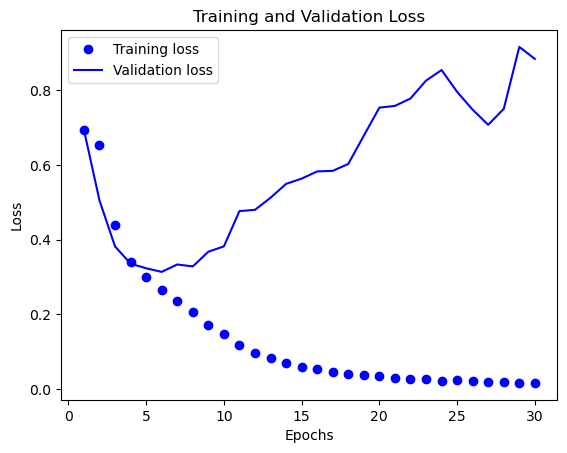

In [267]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

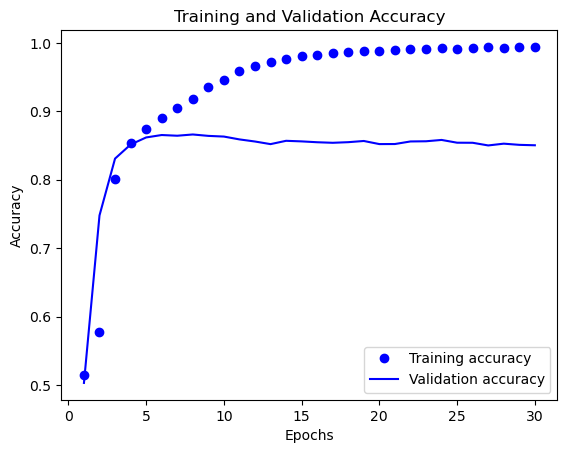

In [268]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 자체 임베딩 vs 사전학습 임베딩

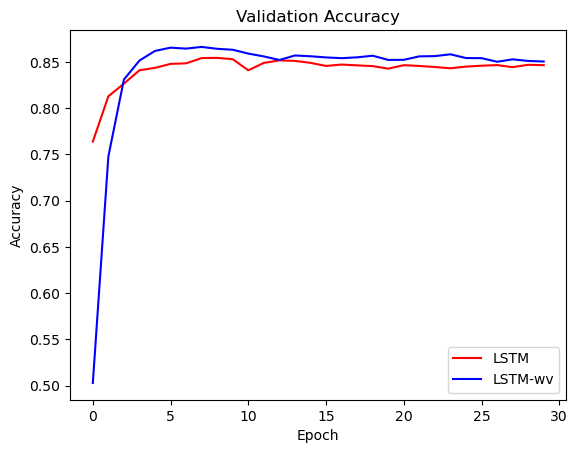

In [269]:
import matplotlib.pyplot as plt

plt.plot(history_lstm['val_accuracy'], 'r', label="LSTM")
plt.plot(history['val_accuracy'], 'b', label="LSTM-wv")


plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

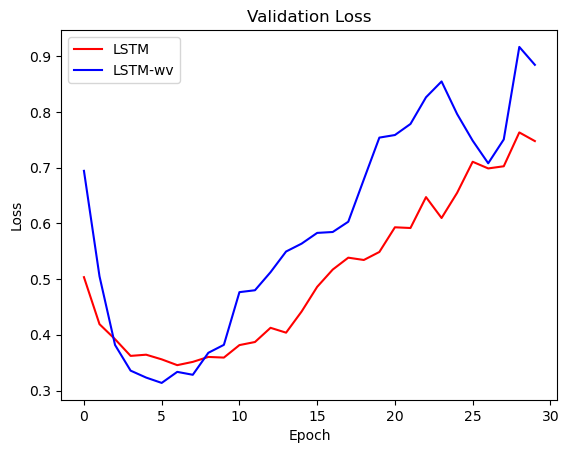

In [270]:
plt.plot(history_lstm['val_loss'], 'r', label="LSTM")
plt.plot(history['val_loss'], 'b', label="LSTM-wv")

plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [272]:
print('LSTM Val acc: ', max(history_lstm['val_accuracy']))
print('LSTM-wv Val acc: ', max(history['val_accuracy']))

print('LSTM Test acc: ', history_lstm['test_loss'])
print('LSTM-wv Test acc: ', history['test_acc'])


LSTM Val acc:  0.854225
LSTM-wv Val acc:  0.866075
LSTM Test acc:  0.8474479728217751
LSTM-wv Test acc:  0.8502146184673597


#### 자체 임베딩과 사전학슴 임베딩의 정량적 비교

|Model|Val-acc|Test-acc|
|------|---|---|
|LSTM|85.42|84.74|
|LSTM-wv|86.61|85.02|


- 자체 임베딩 방법보다 사전학습된 임베딩 방법의 정확도 성능이 더 높았다.
- 사전학습 임베딩을 사용한 LSTM-wv이 Test set에서 85.02%의 정확도를 달성했다.